In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import umap.umap_ as umap
from IPython.display import display

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ella\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ella\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ella\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ella\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Load the original dataset
file_path = "News_Category_Dataset_v3.json"  # Update with actual path
df = pd.read_json(file_path, lines=True)

# Count rows and columns of the original dataset
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")

# Display the head of the dataset
display(df.head())

# Remove white space or empty strings and replace them with None
df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)

# Count and identify null values
null_counts = df.isnull().sum()
print(f"Null values in each column:\n{null_counts}")

# Count duplicated rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicated rows: {duplicate_count}")

# Drop rows with null values in 'headline' or 'short_description'
df = df.dropna(subset=['headline', 'short_description'])

# Drop duplicate rows
df = df.drop_duplicates()

# Convert 'date' column to datetime and retain only rows from 2017 to 2022
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[df['date'].dt.year.isin(range(2017, 2023))]

# Print dataset shape after cleaning
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

# Combine 'headline' and 'short_description' into a single text field
df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Number of rows in original dataset: 209527
Number of columns in original dataset: 6


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


C:\Users\Ella\AppData\Local\Temp\ipykernel_17188\2333260322.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [4]:
# Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [5]:
# Tokenize, remove stopwords, and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [6]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.7, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df['filtered_text'])

In [7]:
svd = TruncatedSVD(n_components=min(X.shape[1],3800) , random_state=42)
X_svd = svd.fit_transform(X)

# UMAP Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

c:\Users\Ella\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ella\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_umap)

In [9]:
from sklearn.model_selection import ParameterGrid

#PARAMETER TUNING

# Define the parameter grid
param_grid = {
    'eps': [0.1, 0.6, 0.7, 0.8, 1.0],
    'min_samples': [3, 6, 11, 16, 18]
}

# Initialize variables to store the best parameters and score
best_params = None
best_score = -1

# Iterate over the parameter grid
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X_normalized)
    
    # Exclude noise points for evaluation
    mask = labels != -1
    if len(set(labels[mask])) > 1:
        score = silhouette_score(X_normalized[mask], labels[mask])
        if score > best_score:
            best_score = score
            best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.4f}")

Best Parameters: {'eps': 0.1, 'min_samples': 3}
Best Silhouette Score: -0.2062


In [10]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_normalized)
df['cluster_dbscan'] = dbscan_labels
print("DBSCAN clustering completed.")

DBSCAN clustering completed.


In [11]:
# Compute clustering metrics (excluding noise cluster -1)
valid_clusters = set(dbscan_labels) - {-1}  # Remove noise points

if len(valid_clusters) > 1:
    silhouette = silhouette_score(X_normalized, dbscan_labels)
    davies_bouldin = davies_bouldin_score(X_normalized, dbscan_labels)
    calinski_harabasz = calinski_harabasz_score(X_normalized, dbscan_labels)
else:
    silhouette, davies_bouldin, calinski_harabasz = -1, -1, -1

# Compute Adjusted Rand Index and Normalized Mutual Info Score
adjusted_rand = adjusted_rand_score(dbscan_labels, dbscan_labels)
nmi = normalized_mutual_info_score(dbscan_labels, dbscan_labels)

# Compute average cosine similarity in a memory-efficient way
from sklearn.metrics.pairwise import cosine_similarity

# Compute average cosine similarity in a memory-efficient way
cosine_sim = cosine_similarity(X_normalized)
avg_cosine_similarity = np.mean(cosine_sim)

# Print clustering metrics
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")

Silhouette Score: -0.2062
Davies-Bouldin Score: 0.5263
Calinski-Harabasz Score: 101.1403
Adjusted Rand Index: 1.0000
Normalized Mutual Information: 1.0000
Average Cosine Similarity: 0.0000


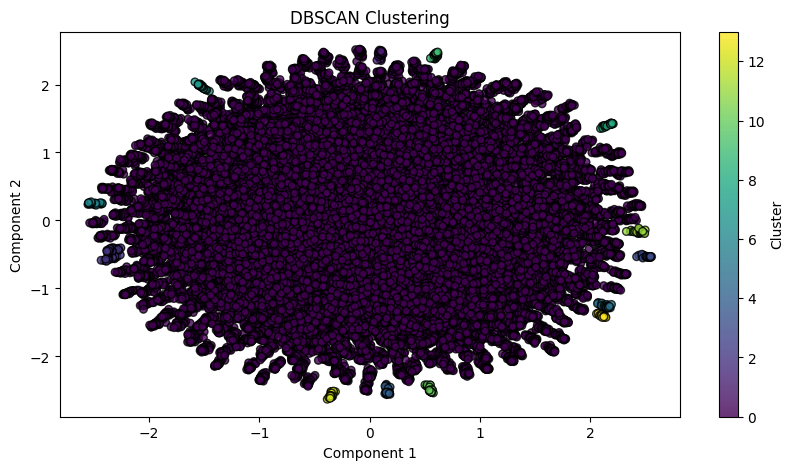

In [12]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=dbscan_labels, cmap='viridis', s=30, edgecolor='k', alpha=0.8)
plt.title('DBSCAN Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label="Cluster")
plt.show()

In [13]:
# Print the number of clusters
num_clusters = len(valid_clusters)
print(f"Number of clusters: {num_clusters}")

# List the first 5 dominant words in each cluster
def get_top_n_words(cluster_labels, n=5):
    cluster_words = {}
    for cluster in valid_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_texts = df.iloc[cluster_indices]['filtered_text']
        all_words = ' '.join(cluster_texts).split()
        word_freq = pd.Series(all_words).value_counts()
        cluster_words[cluster] = word_freq.head(n).index.tolist()
    return cluster_words

top_words = get_top_n_words(dbscan_labels)
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Number of clusters: 14
Cluster 0: thefunniesttweetsfromwomenthisweektheladiesoftwitterneverfailtobrightenourdayswiththeirbrilliantbutsuccinctwisdomeachweekhuffpostwomen, thefunniesttweetsfromparentsthisweekkidsmaysaythedarndestthingsbutparentstweetabouttheminthefunniestwayssoeachweekweroundupthemosthilarious, huffpostheadlinequizapriltoaprilreadyforachallenge, thealtlitewhitehousereporterwhogotarrestedatuconnhasaheavilyracistroadietheformerproudboymarchedwithwhitesupremacistsincharlottesville, thebestchancetodefeatroymooremaybeforthedemocraticpartytolielowdemocratdougjonesistryingtodistinguishhimselffromthenationalpartywhilescandalswirlsaroundhisgopsenaterival
Cluster 1: jamescameronpresentsnewscenesfromavatarthewayofwateratdexpothedirectortoldtheaudiencehewassuperexcitedtobefinallyfinishingupmovietwoashehasthreeadditionalinstallmentsintheworks, thebigsickstarsaysaproduceronceaskedifshespatorswallowedonsetzoekazanrecentlyopenedupaboutsexualharassmentshesexperiencedintheindustry, obamac